In [191]:
#tensorflow:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
#standard libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#own libs
import utils
from model import MODEL

In [238]:
#GLOBAL VARIABLES:
USE_PCT_CHANGE = True
ONLY_USE_MACD = False
USE_MACD = True
#STYLE = "daily"
STYLE = "hourly"

TICKERS = ["BTC-USD"]
#cols_available = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
COLS = ["Close"]
SEQUENCE_LENGTH = 7

In [239]:
#functions:
def to_sequence_target(data, seq_size, target="Close", target_index=0):
    input_dims = data.shape
    n_series = int(input_dims[0] / seq_size)
    x = np.empty((n_series, seq_size, input_dims[1]))
    y = np.empty((n_series, 1))
    for i in range(n_series):
        try:
            x[i] = data.values[i:i+seq_size]
            y[i] = data[target].values[i+seq_size+1]
        except AttributeError:
            x[i] = data[i:i+seq_size, :]
            y[i] = data[i+seq_size+1, target_index]
        
    print("Created X array with shape: {}".format(x.shape))
    print("Created Y array with shape: {}".format(y.shape))
    return x, y 

def to_sequence(data, seq_size):
    input_dims = data.shape
    n_series = int(input_dims[0] / seq_size)
    x = np.empty((n_series, seq_size, input_dims[1]))
    y = np.empty((n_series, input_dims[1]))
    for i in range(n_series):
        try:
            x[i] = data.values[i:i+seq_size]
            y[i] = data.values[i+seq_size+1]
        except AttributeError:
            x[i] = data[i:i+seq_size]
            y[i] = data[i+seq_size+1]
            
    print("Created X array with shape: {}".format(x.shape))
    print("Created Y array with shape: {}".format(y.shape))
    return x, y 

In [240]:
if STYLE == "daily":
    interval = "1d"
    start_date = None
elif STYLE == "hourly":
    interval = "60m"
    start_date = pd.to_datetime("today") - pd.Timedelta("729d")
data = utils.download_data(tickers=TICKERS, start=start_date, interval=interval, value=None)
data = data[COLS]
if USE_MACD:
    #insert macd analysis here:
    macd_model = MODEL(tickers=TICKERS)
    macd_model.get_data(start=start_date, interval=interval)
    macd_model.eval_model()
    data["MACD_GRAD"] = macd_model.grad[TICKERS[0]]
#drop some useless rows:
try:
    data = data[data["Volume"] != 0]
except KeyError:
    pass
if USE_PCT_CHANGE:
    data = data.pct_change()
    data.dropna(inplace=True)
if ONLY_USE_MACD:
    data = data["MACD_GRAD"]
data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
|                                 PRICE MODEL                                  |
|                                 Version 1.0                                  |
|                 Authors: Patrick Lorenz &  Marco Rosenzweig                  |
--------------------------------------------------------------------------------
|                             ticker = ['BTC-USD']                             |
|                            start date = 10/01/18                             |
|                             end date = 09/29/20                              |
|                     initial investment per ticker = 200                      |
[INIT]: Initialising model for tickers: ['BTC-USD']
[INIT]: Successfully initialized model.
********************************************************************************
[TICKER]: BTC-USD
[INFO]: No tax paid.
--

,Close,MACD_GRAD
Datetime,,
2018-10-01 15:00:00+01:00,-0.000043,3.395988
2018-10-01 16:00:00+01:00,-0.000308,-7.955142
2018-10-01 17:00:00+01:00,0.003127,0.867137
2018-10-01 18:00:00+01:00,0.000225,-0.237337
2018-10-01 19:00:00+01:00,0.000823,-0.843906
...,...,...
2020-09-29 11:00:00+01:00,0.004999,0.123725
2020-09-29 12:00:00+01:00,-0.000438,-0.449962
2020-09-29 13:00:00+01:00,-0.001230,-0.397609


In [241]:
data_train = data[data.index <= "2020-05"]
data_test = data[data.index > "2020-05"]
#check shapes:
if isinstance(data_train, pd.Series):
    data_train = np.expand_dims(data_train, -1)
if isinstance(data_test, pd.Series):
    data_test = np.expand_dims(data_test, -1)
#scale data:
scaler = MinMaxScaler()
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)
#split data:
x_train, y_train = to_sequence(data_train, SEQUENCE_LENGTH)
x_test, y_test = to_sequence(data_test, SEQUENCE_LENGTH)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

Created X array with shape: (1967, 7, 2)
Created Y array with shape: (1967, 2)
Created X array with shape: (517, 7, 2)
Created Y array with shape: (517, 2)


In [242]:
activation_function = "relu" #"softsign" 
loss_function = "mse", #"sparse_categorical_crossentropy"
metrics = ["mean_squared_error"]
optimizer = Adam(lr=0.001, decay=1e-6)

#init:
model = Sequential()
model.add(LSTM(units=50, 
               return_sequences=True, 
               activation=activation_function, 
               input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
#hidden layers:
model.add(LSTM(units=50, 
               return_sequences=True, 
               activation=activation_function))
model.add(Dropout(0.2))
model.add(LSTM(units=50, 
               return_sequences=True, 
               activation=activation_function))
model.add(Dropout(0.2))
model.add(LSTM(units=50, 
               activation=activation_function))
model.add(Dropout(0.2))
#final layer:
model.add(Dense(units=x_train.shape[2]))


model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
model.summary()
history = model.fit(x_train, y_train, batch_size=4, epochs=5)

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_132 (LSTM)              (None, 7, 50)             10600     
_________________________________________________________________
dropout_132 (Dropout)        (None, 7, 50)             0         
_________________________________________________________________
lstm_133 (LSTM)              (None, 7, 50)             20200     
_________________________________________________________________
dropout_133 (Dropout)        (None, 7, 50)             0         
_________________________________________________________________
lstm_134 (LSTM)              (None, 7, 50)             20200     
_________________________________________________________________
dropout_134 (Dropout)        (None, 7, 50)             0         
_________________________________________________________________
lstm_135 (LSTM)              (None, 50)              

17/17 [==============================] - 0s 5ms/step - loss: 4.6514e-04 - mean_squared_error: 4.6514e-04


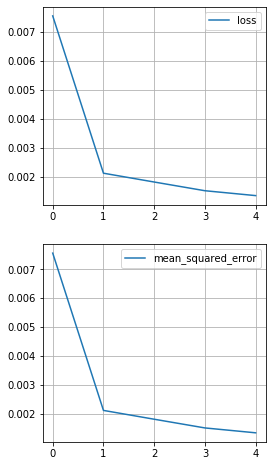

In [243]:
scores = model.evaluate(x_test, y_test)
keys = history.history.keys()
fig, ax = plt.subplots(nrows=len(keys), figsize=(4, 4*len(keys)))
for n, key in enumerate(keys):
    ax[n].plot(history.history[key], label=key)
    ax[n].legend()
    ax[n].grid()

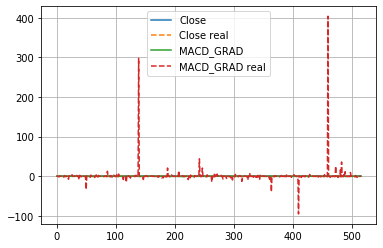

In [244]:
predicted = scaler.inverse_transform(model.predict(x_test))
real = scaler.inverse_transform(y_test)
try:
    labels = data.columns
    for i, label in enumerate(labels):
        if label == "Volume":
            continue
        plt.plot(predicted[:, i], label=label)
        plt.plot(real[:, i], label=labels[i] + " real", ls="--")
except AttributeError:
    plt.plot(predicted, label="prediction")
    plt.plot(real, label="real")
plt.grid()
plt.legend()
plt.show()